### Convergence analysis

In [ ]:
import os
import numpy as np
import jax
import jax.numpy as jnp
from matplotlib import pylab as plt

import nxcl
from nxcl.config import load_config, save_config, add_config_arguments, ConfigDict

from utils.parse import *
from utils.tree_util import *

from utils.metadata import get_nist, get_cifar
import pickle
from utils.metadata import *

import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
import gdown
id = "1T04CsJSS2ku-lx5I17TOsQVZuLQFpX_S"
output = './result/eval.zip'
gdown.download(id=id, output=output)
!unzip -q ./result/eval.zip

### Model Path

In [26]:
### c10
model1_path = './result/eval/c10_frn/2024_1_30_74550'
model2_path = './result/eval/c10_frn/2024_1_30_105910'
model3_path = './result/eval/c10_frn/2024_1_30_23418'

### ESS

In [29]:
# A6000
csg_epoch = 1.7938
meta_epoch = 2.4441
l2e_epoch = 2.645

In [31]:
lopt_ess_list = []

for model_path in [model1_path, model2_path , model3_path]:
    with open(f'{model_path}/model.pickle', 'rb') as f:
        param_list = pickle.load(f)
    flatten_param_list = [np.asarray(jax.flatten_util.ravel_pytree(params)[0]) for params in param_list]
    states = jnp.stack(flatten_param_list,0)
    lopt_ess = tfp.mcmc.effective_sample_size(states=states, filter_beyond_positive_pairs=False)
    # print(np.sum(lopt_ess))
    lopt_ess_list.append(np.sum(lopt_ess))

mean, std = np.asarray(lopt_ess_list).mean(), np.asarray(lopt_ess_list).std()
print(mean/l2e_epoch/100000, std/l2e_epoch/100000)

82.97792060491493 0.5161746810018903


### R hat

In [7]:
state_list = []

for model_path in [model1_path, model2_path , model3_path]:
    with open(f'{model_path}/model.pickle', 'rb') as f:
        param_list = pickle.load(f)
    flatten_param_list = [np.asarray(jax.flatten_util.ravel_pytree(params)[0]) for params in param_list]
    states = jnp.stack(flatten_param_list,0)
    state_list.append(states)

total_chain = jnp.stack(state_list,1)
# print(total_chain.shape)
Rhat_lopt = tfp.mcmc.diagnostic.potential_scale_reduction(total_chain, independent_chain_ndims=1)

len(Rhat_lopt[Rhat_lopt <1.2])/len(Rhat_lopt)

0.920021542025393

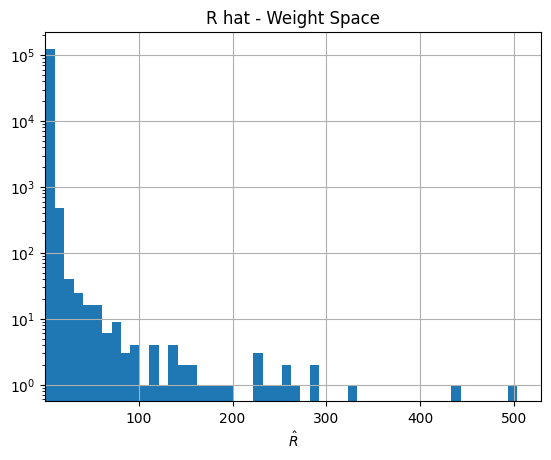

In [81]:
plt.hist(Rhat_lopt, log=True, bins=50)
plt.xlabel('$\^{R}$')
plt.title('R hat - Weight Space')
plt.grid(True)
plt.xlim(0.5, plt.xlim()[1])
plt.show()